**Proof of Concept**: In this section, we first provide proof of concept to our idea of proposing novel Bellman relaxation operator for Q-learning design.

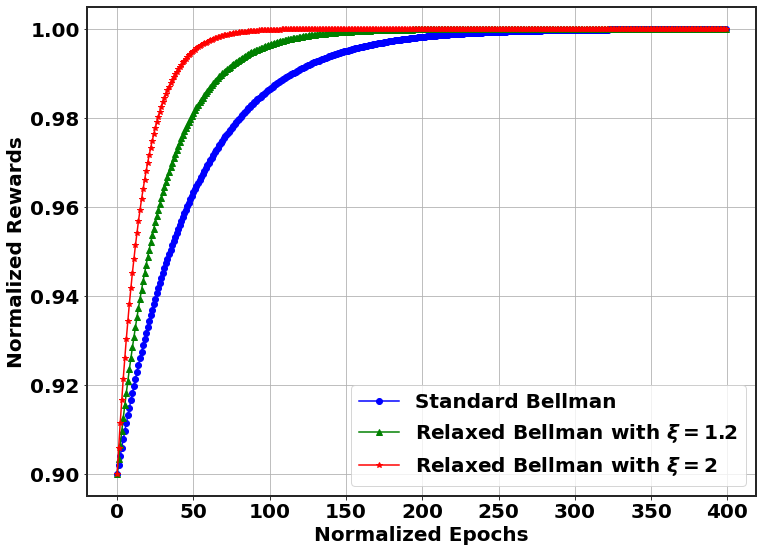

In [7]:
# ------------------------------------>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Proof of concept<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<---------------------------------------
# Import libraries for providing proof of concept.
import numpy as np
import matplotlib.pyplot as plt

# Defining dummy parameters
R=10            # Reward
gam=0.8         # Discount factor
tstep=0.1       # Time step
iter=100        # Iter
# Relaxation parameter
xi1=1.2       
xi2=2

test=[]
test2=[]
test3=[]
for i in range(iter*10):
  test.append((np.exp((gam-1)*i*tstep)-R)/(gam-1))                 # Conventional Bellman convergence behaviour
  test2.append((np.exp((gam-xi1)*i*tstep/xi1)-R)/(gam-xi1))        # Bellman with relaxation parameter \xi = 1.2 - convergence behaviour
  test3.append((np.exp((gam-xi2)*i*tstep/xi2)-R)/(gam-xi2))        # Bellman with relaxation parameter \xi = 2 - convergence behaviour

test=test/np.max(test)
test2=test2/np.max(test2)
test3=test3/np.max(test3)

plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 20, 'font.weight': 'bold'})
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 2
fig = plt.figure(figsize=(12, 9))
edx=400
plt.plot(test[:edx], label = 'Standard Bellman',color = 'blue', marker='o')
plt.plot(test2[:edx], label = r'Relaxed Bellman with $\xi=1.2$',color = 'green', marker='^')
plt.plot(test3[:edx], label = r'Relaxed Bellman with $\xi=2$',color = 'red', marker='*')
plt.xlabel('Normalized Epochs',fontweight='bold')
plt.ylabel('Normalized Rewards',fontweight='bold')
plt.grid()
plt.legend()
plt.show()


fig.savefig('plot2.png', dpi=300, bbox_inches = "tight")
np.save('relax_std.npy',test)
np.save('relax_1.npy',test2)
np.save('relax_2.npy',test3)

# ------------------------------------>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Proof of concept<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<---------------------------------------

Here, we first design the PBCN model to be used as an environment for providing peer-to-peer comparison for conventional Q-learning versus relaxed Q-learning. 

Graph with combination U=0


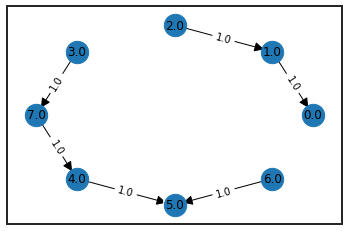

Graph with combination U=1


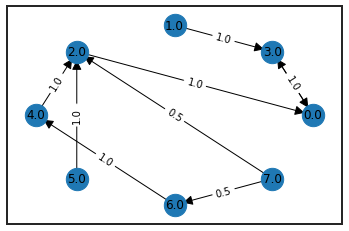

In [8]:
# Import libraries required for PBCN problem
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import multiprocessing as mp
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import pylab as plt
import networkx as nx
import numpy as np
import time
import sys

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Creating PBCN Parameters <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

ns = 3  # Number of State variables
nc = 1  # Number of Control variables
n = ns + nc # Total variables

# Generate table of all possible binary combinations between states-action pairs
table = list(itertools.product([0, 1], repeat=n))

# function to convert boolean to decimal values
def bool2dec(table_name,n_val,table_len,flag):
  dec_value=np.zeros(table_len)
  for i in range(0,table_len):
    for j in range(0,n_val):
      if flag==0:                          # flag defines if control u is taken into consideration or not
        dec_value[i]=(np.power(2,(n_val-j-1)))*table_name[i][j+nc]+dec_value[i] # for u at the beginning
      else:
        dec_value[i]=(np.power(2,(n_val-j-1)))*table_name[i][j]+dec_value[i] # for u at the beginning
  return dec_value

value=bool2dec(table,ns,len(table),0)
df=pd.DataFrame([table[0:len(table)],value])        # Dataframe comprising of state-action pairs and corresponding decimal values

no_of_perm = 2                                      # no of possible permutations in reference to states possessing sub network structure
no_of_vars_with_diff_paths = 1                      # no of variables possesing sub networks
if no_of_vars_with_diff_paths==1:
  f = np.zeros([ns+int(no_of_vars_with_diff_paths),df.shape[1]])    # f=[[f11f21f31],[f11f22f31],[f12f21f31]...] all possible dynamical functions
else:
  f = np.zeros([ns+int(no_of_perm/no_of_vars_with_diff_paths),df.shape[1]])     # f=[[f11f21f31],[f11f22f31],[f12f21f31]...] all possible dynamical functions

# Boolean dynamics of the system given by x_{k+1} = f_{x_{k},u_{k}}
for i in range(0,df.shape[1]):
  f[0,i]=(1-df[i][0][0] and df[i][0][1]) or (df[i][0][1] and df[i][0][2]) or (1-df[i][0][0] and df[i][0][2] and df[i][0][3]) 
  f[1,i]=(1-df[i][0][0] and df[i][0][1]) or (df[i][0][1] and df[i][0][2] and (1-df[i][0][3])) or (1-df[i][0][0] and df[i][0][2] and df[i][0][3])
  f[2,i]=(df[i][0][0] and (1-df[i][0][2])) or (df[i][0][0] and df[i][0][1] and df[i][0][3]) or (1-df[i][0][0] and (1-df[i][0][1]) and df[i][0][2] and df[i][0][3])
  f[3,i]=(1-df[i][0][0] and (1-df[i][0][1]) and df[i][0][2]) or (1-df[i][0][0] and (df[i][0][2]) and (1-df[i][0][3])) or (1-df[i][0][0] and (df[i][0][1]) and (1-df[i][0][2])) or (df[i][0][0] and (1-df[i][0][1]) and (1-df[i][0][2]))

# creating and storing dataframes for individual sub networks
dummy_df=pd.DataFrame([f[0,:],f[2,:],f[3,:]])
df2=pd.DataFrame([f[0,:],f[2,:],f[3,:],bool2dec(dummy_df,ns,df.shape[1],1)])    # subnetwork with combination: sc1 = f11,f21,f31
dummy_df=pd.DataFrame([f[1,:],f[2,:],f[3,:]])
df3=pd.DataFrame([f[1,:],f[2,:],f[3,:],bool2dec(dummy_df,ns,df.shape[1],1)])    # subnetwork with combination: sc1 = f12,f21,f31

pc = np.ones(f.shape[0])
pc[0]=0.5     # probability associated with f11
pc[1]=0.5     # probability associated with f12
pc[2]=1.0     # probability associated with f21
pc[3]=1.0     # probability associated with f31


points_list_U1=list()     # transitions in decimal form with control u = 0
points_list_U2=list()     # transitions in decimal form with control u = 1
edge_weights_U1={}        # probabilities of transitions with control u = 0
edge_weights_U2={}        # probabilities of transitions with control u = 1

# notations indicating control chosen
control_dict={0:"u=0",
             1:"u=1",
            -1:"No Control"}

c = np.power(2,ns)
for i in range(np.power(2,ns)):                           # transitions are calculated in reference to the underlying dynamical equations and corresponding probabilities are stored
  points_list_U1.append((df[i].iloc[-1],df2[i].iloc[-1]))
  edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[2]*pc[3],2))
  points_list_U1.append((df[i].iloc[-1],df3[i].iloc[-1]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[1]*pc[2]*pc[3],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[1]*pc[2]*pc[3],2))

  points_list_U2.append((df[i+c].iloc[-1],df2[i+c].iloc[-1]))
  edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[2]*pc[3],2))
  points_list_U2.append((df[i+c].iloc[-1],df3[i+c].iloc[-1]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[1]*pc[2]*pc[3],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[1]*pc[2]*pc[3],2))
  

# function to calculate possible attractors of the given PBCN
def find_Attractors(G,nx):
  number_of_attractor = nx.number_attracting_components(G)
  a_list = list(nx.attracting_components(G))
  return a_list

# Visualizing the graphs for u = 0
print("Graph with combination U=0")
GU1=nx.DiGraph()
GU1.add_edges_from(points_list_U1)
posU1=nx.circular_layout(GU1)
nx.draw_networkx_nodes(GU1,posU1,node_size=500)
nx.draw_networkx_edges(GU1,posU1,arrowstyle='-|>',arrowsize=20,arrows=True)
nx.draw_networkx_labels(GU1,posU1)
nx.draw_networkx_edge_labels(GU1,posU1,edge_labels=edge_weights_U1)
plt.show()

# Calculating and saving attractors for individual control actions
attractor_set = []
a_calc = find_Attractors(GU1,nx)
attractor_set.append(a_calc)

# Visualizing the graphs for u = 1
print("Graph with combination U=1")
GU2=nx.DiGraph()
GU2.add_edges_from(points_list_U2)
posU2=nx.circular_layout(GU2)
nx.draw_networkx_nodes(GU2,posU2,node_size=500)
nx.draw_networkx_edges(GU2,posU2,arrowstyle='-|>',arrowsize=20,arrows=True)
nx.draw_networkx_labels(GU2,posU2)
nx.draw_networkx_edge_labels(GU2,posU2,edge_labels=edge_weights_U2)
plt.show()

a_calc = find_Attractors(GU2,nx)
if a_calc not in attractor_set:
  attractor_set.append(a_calc)

# Creating probability transition matrices for existent sub networks.
probs_U1=np.zeros([np.power(2,ns),np.power(2,ns)])
probs_U2=np.zeros([np.power(2,ns),np.power(2,ns)])
for i in range(len(points_list_U1)):
  probs_U1[int(points_list_U1[i][0])][int(points_list_U1[i][1])]=edge_weights_U1[points_list_U1[i]]
  probs_U2[int(points_list_U2[i][0])][int(points_list_U2[i][1])]=edge_weights_U2[points_list_U2[i]]


# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Creating PBCN Parameters <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------


Next, we use Q-learning to compare relaxed Bellman with conventional structure for analysis.

0.77 % complete.
1.64 % complete.
2.52 % complete.
3.4 % complete.
4.28 % complete.
5.15 % complete.
6.03 % complete.
6.91 % complete.
7.79 % complete.
8.66 % complete.
9.54 % complete.
10.42 % complete.
11.29 % complete.
12.17 % complete.
13.05 % complete.
13.93 % complete.
14.8 % complete.
15.68 % complete.
16.56 % complete.
17.43 % complete.
18.31 % complete.
19.19 % complete.
20.07 % complete.
20.94 % complete.
21.82 % complete.
22.7 % complete.
23.57 % complete.
24.45 % complete.
25.33 % complete.
26.21 % complete.
27.08 % complete.
27.96 % complete.
28.84 % complete.
29.71 % complete.
30.59 % complete.
31.47 % complete.
32.35 % complete.
33.22 % complete.
34.1 % complete.
34.98 % complete.
35.86 % complete.
36.73 % complete.
37.61 % complete.
38.49 % complete.
39.36 % complete.
40.24 % complete.
41.12 % complete.
42.0 % complete.
42.87 % complete.
43.75 % complete.
44.63 % complete.
45.5 % complete.
46.38 % complete.
47.26 % complete.
48.14 % complete.
49.01 % complete.
49.89 % c

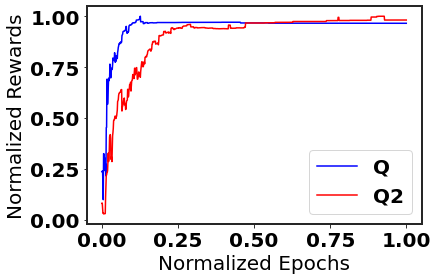

In [27]:

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Defining and implementing RL control <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

# Model-free Reinforcement Learning

# Define parameters required for Q-learning
num_nodes=np.power(2,ns)
initial_state=np.random.choice(range(num_nodes-1))
goal=0                                              # desired attractor: 111-1 or decimal-7
undesired_goals=[3,5]                               # undesired attractors: decimal - 3,5
gamma=0.8                                           # discount factor: \gamma \in [0,1)
lr=0.8                                              # learning rate: \alpha \in (0,1]
EPSILON=0.1                                         # initialising \epsilon in \eplsion-greedy policy

# Environment variables
PTM2=np.stack((probs_U1,probs_U2))                  # Defining probability transitions matrix for tabular learning
PTM=np.stack((edge_weights_U1,edge_weights_U2))     # Defining probability transitions matrix for function aprroximator learning
proportional_factor = 1.0                           # Proportionality factor for creating rewards


R = proportional_factor*PTM2                        # Rewards given by the environment for tabular learning
# assign maximum reward of 100 to possible paths that lead to desired attractor
for j in range(PTM2.shape[0]):
  for i in range(PTM2.shape[1]):
    for k in range(PTM2.shape[2]):
      if PTM2[j,i,k]!=0 and k == goal:
        R[j,i,k]=100*float(PTM2[j,i,k])             # Provide proportionate rewards in order to make sure that only those states that reach desired attractors with probability 1 are given maximum rewards
      elif PTM2[j,i,k]!=0 and k in undesired_goals:
        R[j,i,k]=-30                                # Provide negative rewards in order to make sure that the states reaching undesired attractors are given negative rewards

# Model-free Controller using Q-learning
Q=np.zeros([np.power(2,ns),np.power(2,nc)]) # Initialize relaxed Q table to zeros with dimensions defined by states-action pairs
Q2=np.zeros([np.power(2,ns),np.power(2,nc)]) # Initialize Q table to zeros with dimensions defined by states-action pairs

# Relaxation parameter for comparison
xi=5

# Relaxed Bellman operator Q-learning
def Q_learning(current_state, current_action, next_state, gamma):
  max_index=np.squeeze(np.where(Q[int(next_state),:]==np.max(Q[int(next_state),:])))      # a*=\underset{a \in A(s)}{\arg \max}(Q(s,a))

  if max_index.size > 1:
      max_index = int(np.random.choice(max_index, size = 1))
  else:
      max_index = int(max_index)
  max_value = Q[int(next_state), max_index]                   # Q* = Q(s',a*)
  
  # Q(s,a) \leftarrow [Q(s,a) + \alpha((R + \gamma Q*)/\xi - Q(s,a))]
  Q[int(current_state), int(current_action)] = (Q[int(current_state), int(current_action)] + lr*((R[int(current_action), int(current_state), int(next_state)]+gamma*max_value)/xi - gamma*Q[int(current_state), int(current_action)]))

  # Store normalized score of overall Q matrix as MDP
  if (np.max(Q) > 0):
    return((np.sum(Q/np.max(Q)*100)))     # score = \sum \frac{Q}{\max Q}
  else:
    return((0))

# Conventional Q-learning
def Q_learning2(current_state, current_action, next_state, gamma):
  max_index=np.squeeze(np.where(Q2[int(next_state),:]==np.max(Q2[int(next_state),:])))      # a*=\underset{a \in A(s)}{\arg \max}(Q(s,a))

  if max_index.size > 1:
      max_index = int(np.random.choice(max_index, size = 1))
  else:
      max_index = int(max_index)
  max_value = Q2[int(next_state), max_index]                   # Q* = Q(s',a*)
  
  # Q(s,a) \leftarrow [Q(s,a) + \alpha(R + \gamma Q* - Q(s,a))]
  Q2[int(current_state), int(current_action)] = (Q2[int(current_state), int(current_action)] + lr*(R[int(current_action), int(current_state), int(next_state)] + gamma * max_value - Q2[int(current_state), int(current_action)]))

  # Store normalized score of overall Q matrix as MDP
  if (np.max(Q2) > 0):
    return((np.sum(Q2/np.max(Q2)*100)))     # score = \sum \frac{Q}{\max Q}
  else:
    return((0))

Q_algo=[]     # Initialize a dummy Q as a placeholder in greedy algo for Q
def greedy_policy_Q(state,Q_algo):
  action_prob = np.ones(np.power(2,nc))*EPSILON/np.power(2,nc)      # define action probabilities as \epsilon/|A(s)|
  # choose best action to be a*=\underset{a\in A(s)}{\arg \max} Q
  best_action = np.squeeze(np.where(Q_algo[state,:]==np.max(Q_algo[state,:])))   
  if best_action.size>1:
    best_action = np.random.choice(best_action,size=1)
  action_prob[best_action]+=(1-EPSILON)                             # for a* set action probability = \epsilon/|A(s)| + (1-\epsilon)
  return action_prob

# Define environment as: [current_state, next_state, action, reward] = env(current_state, Q_algo), where Q_algo is Q.
def env_Q(current_state,Q_algo):
  action_probabilities = greedy_policy_Q(current_state,Q_algo)                                  # calculate action probabilities using greedy policy
  action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)     # calculate action
  if action.size > 1:                  # if there are multiple actions choose any one randomly and for the chosen random action, choose single next_state if multiple transitions are possible
    action = int(np.random.choice(action,size=1))
    next_state = int(np.squeeze(np.where(PTM2[action,current_state,:]>0)))
    if next_state.size>1:
      next_state = int(np.random.choice(np.squeeze(np.where(PTM2[action,current_state,:]>0)),size=1))
    else:
      next_state = int(np.squeeze(np.where(PTM2[action,current_state,:]>0)))
  else:
    next_state = np.squeeze(np.where(PTM2[action,current_state,:]>0))
    if next_state.size>1:
      next_state = int(np.random.choice(np.squeeze(np.where(PTM2[action,current_state,:]>0)),size=1))
    else:
      next_state = int(np.squeeze(np.where(PTM2[action,current_state,:]>0)))
  reward = R[action,current_state,next_state]

  return np.array([current_state,next_state,action,reward])


# ------------------------>>>>>>>>>>>>>>>>> Training Module <<<<<<<<<<<<<<<<----------------------------
start_time = time.time()                  # start the timer to time overall code execution

# Initialize overall normalized score for both the algorithms
scores_Q = []
scores_Q2 = []
# Define parameters for exploration-exploitation type learning starting from complete exploration to near exploitation of target Q values.
EPSILON = 1.0
EPSILON_DECAY_RATE = 0.95
EPSILON_MIN = 0.05
EPSILON_DECAY_ITER = 8
MAX_ITER = np.power(2,ns) + int(np.power(2,ns)/REPLAY_BUFFER_MAX) + (REPLAY_BUFFER_MAX-BATCH)*REPLAY_BUFFER_MAX + 900 # Optimal iterations as number of states + (number of states/RB_{cap}) + extra steps, if required.

cnt=0

for j in range(MAX_ITER):

  # populate Q values in Q-learning and generate normalized score for evaluation
  # Relaxed Bellman Q-learning
  [current_state,next_state,action,reward] = env_Q(np.random.randint(num_nodes),Q)  # choose random current_state in every iterations and generated Q values accordingly.
  score_Q = Q_learning(current_state,action,next_state,gamma)
  scores_Q.append(score_Q)

  # Conventional Q-learning
  [current_state,next_state,action,reward] = env_Q(np.random.randint(num_nodes),Q2)  # choose random current_state in every iterations and generated Q values accordingly.
  score_Q2 = Q_learning2(current_state,action,next_state,gamma)
  scores_Q2.append(score_Q2)

  cnt+=1

  # reduce epsilon every training step so as to maintain exploration-exploitation
  if EPSILON >= EPSILON_MIN and cnt%EPSILON_DECAY_ITER==0:
    EPSILON*=EPSILON_DECAY_RATE
  

    # print overall progress of the training process.
    print(np.round((j/MAX_ITER)*100,2),'% complete.')
  

# print total time taken for the overall training
print('Total time taken for training of both the algorithms')
print("--- %s seconds ---" % (time.time() - start_time))

# # generate normalized score from successive steps for peer-to-peer comparisons
scores_Q = scores_Q/np.max(scores_Q)
scores_Q2 = scores_Q2/np.max(scores_Q2)

# # generate a linear x-space for plotting
t = np.linspace(0, 1, len(scores_Q))

# # visualize the data
plt.plot(t, scores_Q, label='Q', color = 'blue')
plt.plot(t, scores_Q2, label='Q2', color = 'red')
plt.xlabel('Normalized Epochs')
plt.ylabel('Normalized Rewards')
plt.legend()
plt.show()

# ------------------------>>>>>>>>>>>>>>>>> Training Module <<<<<<<<<<<<<<<<----------------------------

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Defining and implementing RL control <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------


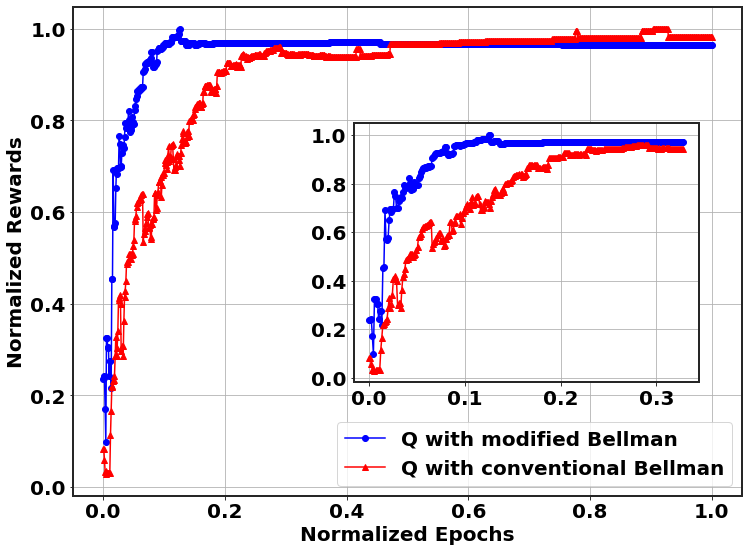

In [33]:
# Visualize data for analysis
plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 20, 'font.weight': 'bold'})
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 2

fig1 = plt.figure(figsize=(12, 9))
ax1 = fig1.add_subplot(111)
ax1.plot(t, scores_Q, label='Q with modified Bellman', color = 'blue', marker='o')
ax1.plot(t, scores_Q2, label='Q with conventional Bellman', color = 'red', marker='^')

plt.xlabel('Normalized Epochs',fontsize='20', fontweight='bold')
plt.ylabel('Normalized Rewards',fontsize='20', fontweight='bold')
plt.grid()
plt.legend()

ax2 = plt.axes([.45, .3, .4, .4])
idx=300
ax2.plot(t[:idx], scores_Q[:idx], label='Q with modified Bellman', color = 'blue', marker='o')
ax2.plot(t[:idx], scores_Q2[:idx], label='Q with conventional Bellman', color = 'red', marker='^')

plt.grid()
plt.show()

fig1.savefig('plot.png', dpi=300, bbox_inches = "tight")

At the end, we verify the controller learnt by both the algorithms to check its capability to stabilize the PBCN.

In [32]:
# Generate heat-maps for analysis
import seaborn as sns

crms=np.transpose(Q)      # Individual Q tables can be replaced here in order to understand the values learnt

np.random.seed(24)
df_dummy = pd.DataFrame({'Q': np.linspace(0, 1, 2)})
df_dummy = pd.concat([df_dummy, pd.DataFrame(crms)],axis=1)

cm = sns.light_palette("blue", as_cmap=True)

s5 = df_dummy.style.background_gradient(cmap=cm)
s5

,Q,0,1,2,3,4,5,6,7
0,0.000000,31.250000,31.250000,6.493007,0.560387,-6.200623,-6.200000,-6.200331,1.550000
1,1.000000,-1.250220,-1.251279,31.250000,31.250000,6.500000,6.500000,1.550000,0.447078
